In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jun 29 13:08:39 2023

@author: c.hages
"""

import sys
import os
import ctypes

import numpy as np
import matplotlib.pyplot as plt

from qcam import Camera
from mono import Mono

from calibration import get_position, to_wavelength, to_raman

In [9]:
camera.close_camera()
camera.release_driver()

: 

In [2]:
camera = Camera()
cameraOpened = camera.connect_to_camera()
# mono = Mono()

Number of cameras found: 1
Camera 1:
	cameraId: 268435456
	cameraType: 6
	uniqueId: 8294
	isOpen: 0
Camera opened with handle 1992996653984


In [3]:
result, model = camera.get_camera_model()
if result != 0:  # Replace with your actual success value
    print(f"Failed to get camera model with error {result}")
else:
    print(f"Camera model: {model}")

# Display Info & Parameters
camera.setup_camera()
print(list(camera.info.values()))
print(list(camera.parameters.values()))
for name, param in camera.parameters.items():
    print(f"For parameter {name}: min_value is {param.min_value}, max_value is {param.max_value}")

# bkg = np.loadtxt("bkg.txt").astype(int)[:, 1]
# out_path = r"."

camera.set_camera_param("Exposure", int(1))  # replace 1000 with the desired exposure value
camera.set_camera_param("Gain", 1023)  # replace 1000 with the desired exposure value
camera.set_camera_param("Binning", 2)  # replace 1000 with the desired exposure value
camera.retrieve_parameters()
print(list(camera.parameters.values()))

Camera model: Retiga 1350B
Failed to retrieve value of parameter Blackout Mode
Failed to retrieve value of parameter High Sensitivity Mode
[Bit Depth: 12, Cooled: 1, Image Width: 1392, Image Height: 1040, Image Size: 1447680, CCD Width: 1392, CCD Height: 1040, Regulated Cooling: 0, Regulated Cooling Lock: 0, High Sensitivity Mode: 0, Blackout Mode: 0]
[Gain: 493, Offset: 2048, Exposure: 16384, Binning: 1, Cooler Active: 1, Image Format: 2, ROI X: 0, ROI Y: 0, ROI Width: 1392, ROI Height: 1040, Normalized Gain: 1000000, Post Processing: 0, Blackout Mode: None, High Sensitivity Mode: None]
For parameter Gain: min_value is 115, max_value is 4095
For parameter Offset: min_value is 0, max_value is 4095
For parameter Exposure: min_value is 10, max_value is 1073741823
For parameter Binning: min_value is 1, max_value is 8
For parameter Cooler Active: min_value is 0, max_value is 1
For parameter Image Format: min_value is 0, max_value is 12
For parameter ROI X: min_value is 0, max_value is 1391

In [4]:
def frame_to_image(frame):
    """
    Convert frame buffer to image array
    Windows doesn't like it (i.e. throws a fatal exception)
    when this takes place in qcam.py for some reason!
    """
    # First we need to cast the void pointer to a pointer to a char array
    pBuffer = ctypes.cast(frame.pBuffer, ctypes.POINTER(ctypes.c_char * frame.size))
    
    # Then we create a numpy array from the buffer
    image_data = np.frombuffer(pBuffer.contents, dtype=np.uint8)
    
    # Now reshape it into the correct shape
    image = image_data.reshape(frame.height, frame.width)
    return image

Parameter Exposure set to 5000000
0


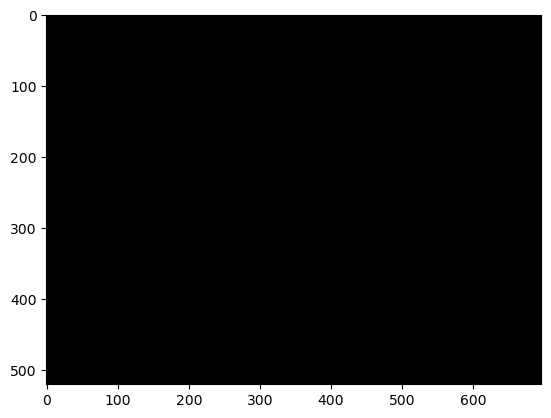

In [8]:
camera.set_camera_param("Exposure", int(5e6)) 
# frame = camera.grab_frame()
frame = camera.grab_frameSingle()

image = frame_to_image(frame)
plt.imshow(image,cmap='gray')

In [18]:
image.shape

(520, 696)

Index of the maximum value: (251, 366)


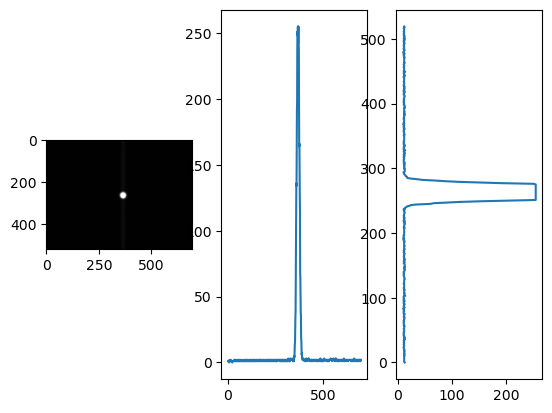

In [27]:
# Find the index of the maximum value in the flattened array
max_index_flat = np.argmax(image)
# Convert the flattened index to 2D indices (row, column)
max_index_2d = np.unravel_index(max_index_flat, image.shape)
iXmax=max_index_2d[0]
iYmax=max_index_2d[1]

plt.figure()
plt.subplot(1,3,1)
plt.imshow(image,cmap='gray')
plt.subplot(1,3,2)
plt.plot(np.arange(image.shape[1]),image[iXmax,:])
plt.subplot(1,3,3)
plt.plot(image[:,iYmax],np.arange(image.shape[0]))



In [ ]:


def frame_to_image(frame):
    """
    Convert frame buffer to image array
    Windows doesn't like it (i.e. throws a fatal exception)
    when this takes place in qcam.py for some reason!
    """
    # First we need to cast the void pointer to a pointer to a char array
    pBuffer = ctypes.cast(frame.pBuffer, ctypes.POINTER(ctypes.c_char * frame.size))
    
    # Then we create a numpy array from the buffer
    image_data = np.frombuffer(pBuffer.contents, dtype=np.uint8)
    
    # Now reshape it into the correct shape
    image = image_data.reshape(frame.height, frame.width)
    return image

if __name__ == "__main__":
    
    try:
        # Create a camera object
        camera = Camera()
        cameraOpened = camera.connect_to_camera()
        mono = Mono()
        
        # =============================================================================
        # Code to get/send paramters to Camera
        # =============================================================================
        
        if cameraOpened:
            result, model = camera.get_camera_model()
            if result != 0:  # Replace with your actual success value
                print(f"Failed to get camera model with error {result}")
            else:
                print(f"Camera model: {model}")
    
            # Display Info & Parameters
            camera.setup_camera()
            print(list(camera.info.values()))
            print(list(camera.parameters.values()))
            for name, param in camera.parameters.items():
                print(f"For parameter {name}: min_value is {param.min_value}, max_value is {param.max_value}")

            bkg = np.loadtxt("bkg.txt").astype(int)[:, 1]
            out_path = r"."

            camera.set_camera_param("Exposure", int(20 * 1e6))  # replace 1000 with the desired exposure value
            camera.set_camera_param("Gain", 1023)  # replace 1000 with the desired exposure value
            camera.set_camera_param("Binning", 2)  # replace 1000 with the desired exposure value
            camera.retrieve_parameters()
            print(list(camera.parameters.values()))
            grating_no = 3
            mono.set_grating(grating_no)
            
            y0 = 150
            y1 = 300
            
            for r in np.arange(50, 600, 5):
                print(r)
                mono.set_raman_shift(r, 532)
                frame = camera.grab_frame()
                image = frame_to_image(frame)
                
                x = get_position(to_wavelength(r, w0=532), image.shape[1],
                                 grating_no=grating_no, binning=2)
                x = to_raman(x, w0=532)

                integral = np.sum(image[y0:y1], axis=0).astype(int)
                integral -= bkg


                plt.figure(r)
                plt.imshow(image, cmap='rainbow')
                plt.axhline(y0, color='r')
                plt.axhline(y1, color='r')
                
                plt.figure(r+1)
                plt.plot(x, integral)
                plt.ylabel("Counts")
                plt.xlabel("WL [nm]")

                np.savetxt(os.path.join(out_path, f"{r}.txt"), np.vstack((x, integral)).T, header="WL [nm]\tCounts", fmt='%.3f', delimiter="\t")
                #np.savetxt("bkg.txt", np.vstack((x, integral)).T, header="WL [nm]\tCounts", fmt="%.3f", delimiter="\t")
            # mono.set_wavelength(10)
            # frame = camera.grab_frame()
            # image = frame_to_image(frame)

            # plt.figure(1)
            # plt.imshow(image, cmap='rainbow')
        
    except SystemExit:
        print("An error occurred, exiting...")

        
    finally:
        mono.close()
        if cameraOpened:
            # Close the camera
            result = camera.close_camera()
            if result != 0:  # Replace with your actual success value
                print(f"Camera closing failed with error {result}")
                sys.exit(1)     
            print("Camera closed successfully")
        if 'camera' in locals():  # Check if camera was defined before trying to release the driver
            camera.release_driver()
            print("Driver released")        